In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.preprocessing import scale
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split

import hervpd as hp
import plotReport as pr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
df = pd.read_csv( 'data/12features/combined.csv')
df.describe()

,user,AVGNN,SDNN,MeanHR,MinHR,MaxHR,RMSSD,pNNxx,TINN,powerVLF,powerLF,powerHF,ratioHFLF
count,544.000000,544.000000,544.000000,544.00000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000
mean,1.187500,758.600000,72.865018,81.37714,67.362033,108.560417,46.409227,20.082227,358.020221,2877.387599,1423.919671,1000.824001,2.753764
std,0.913249,129.785003,32.960406,13.75457,10.849680,36.385572,32.537407,18.316263,146.885899,3619.576847,1443.217366,1841.656665,2.296974
min,0.000000,475.730000,17.833000,51.62800,41.437000,58.117000,4.882500,0.000000,83.000000,85.654000,57.852000,7.977700,0.154680
25%,0.000000,670.362500,51.871500,73.23225,60.292750,91.470250,27.438750,6.593075,258.000000,995.182500,591.307500,258.917500,1.257000
50%,2.000000,750.545000,67.057000,79.94200,66.181500,100.520000,37.994500,15.417500,339.000000,1807.950000,1040.350000,512.090000,2.037350
75%,2.000000,819.307500,85.820000,89.50400,74.285250,112.580000,54.762250,26.790500,426.250000,3304.250000,1697.950000,960.045000,3.579975
max,2.000000,1162.200000,264.250000,126.12000,104.900000,550.320000,240.470000,98.232000,1103.000000,29716.000000,12958.000000,16103.000000,18.228000


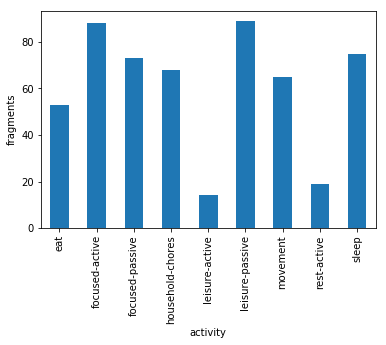

In [8]:
hp.plot_count(df, 'activity')

In [10]:
# exclude activities with too little representation
df = hp.filter_out(df, 'activity', ['rest-active', 'leisure-active'])
print(df.activity.unique())

['eat' 'focused-active' 'focused-passive' 'household-chores'
 'leisure-passive' 'movement' 'sleep']


In [12]:
movelist = ['exercise-high', 'exercise-low', 'movement', 'household-chores']
df = hp.add_partition(df, movelist, pname='move', labelIn='move', labelOut='still')
    
sleeplist = ['sleep']
df = hp.add_partition(df, sleeplist, pname='sleep', labelIn='sleep', labelOut='wake')

df.sample(6)

,user,activity,posture,AVGNN,SDNN,MeanHR,MinHR,MaxHR,RMSSD,pNNxx,TINN,powerVLF,powerLF,powerHF,ratioHFLF,move,sleep
324,2,focused-active,sit,889.05,80.213,67.488,59.488,94.787,59.683,34.5240,364,1237.80,1437.50,1318.00,1.0910,still,wake
244,1,leisure-passive,sit,799.30,65.810,75.066,65.617,92.490,37.050,15.2000,292,2502.50,955.46,528.51,1.8078,still,wake
523,2,sleep,lie,924.23,136.410,64.919,51.458,86.931,61.432,25.6170,692,18418.00,3246.20,811.34,4.0010,still,sleep
83,0,household-chores,stand,575.96,63.002,104.170,80.819,202.130,41.379,6.3707,533,413.27,460.09,160.55,2.8656,move,wake
533,2,sleep,lie,1134.80,56.378,52.871,48.015,60.976,49.659,31.5590,288,1006.00,524.16,623.65,0.8400,still,sleep
480,2,movement,stand,723.38,66.570,82.944,67.950,98.587,22.295,4.1063,277,2163.10,1000.50,271.94,3.6790,move,wake


### Apply scale to make all features turn to gaussians with mean = 0 and SD = 1. That will allow SVM kernels not to put too much weight on features with larger values.

In [13]:
feature_list = ['AVGNN', 'SDNN', 'MeanHR', 'MinHR', 'MaxHR', 'RMSSD', 'pNNxx', 'TINN', 'powerVLF', 'powerLF', 'powerHF', 'ratioHFLF']
df[feature_list] = hp.scaled_features(df, feature_list)
df.describe()

,user,AVGNN,SDNN,MeanHR,MinHR,MaxHR,RMSSD,pNNxx,TINN,powerVLF,powerLF,powerHF,ratioHFLF
count,511.000000,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02
mean,1.189824,-1.929311e-16,-3.006945e-16,-9.942036e-16,9.194645e-16,9.059941e-17,1.342696e-16,1.040698e-16,1.042871e-17,1.142813e-16,-5.170902e-17,4.160621e-17,8.549369e-17
std,0.908119,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00
min,0.000000,-2.137055e+00,-1.676670e+00,-2.137750e+00,-2.362415e+00,-1.373772e+00,-1.313777e+00,-1.109950e+00,-1.888086e+00,-7.717804e-01,-9.417885e-01,-5.493034e-01,-1.136800e+00
25%,0.000000,-6.838934e-01,-6.304033e-01,-6.195035e-01,-6.799283e-01,-4.801817e-01,-6.038868e-01,-7.468693e-01,-6.732240e-01,-5.177532e-01,-5.741279e-01,-4.118293e-01,-6.640603e-01
50%,2.000000,-7.328069e-02,-1.541356e-01,-9.631318e-02,-1.142624e-01,-2.201270e-01,-2.565619e-01,-2.462851e-01,-1.135686e-01,-2.944213e-01,-2.761460e-01,-2.664865e-01,-3.093413e-01
75%,2.000000,4.979229e-01,3.897935e-01,5.933614e-01,6.604105e-01,1.002332e-01,2.880550e-01,3.975070e-01,4.631495e-01,1.211459e-01,1.844318e-01,-1.089094e-02,3.844003e-01
max,2.000000,3.075496e+00,5.793283e+00,3.172352e+00,3.393374e+00,1.182139e+01,6.151021e+00,4.306605e+00,5.073482e+00,7.403906e+00,7.882036e+00,8.543813e+00,6.582587e+00


### Test dataset will have 20% of examples, the other 80% will be for training (with cross-validation)

In [14]:
train, test = train_test_split(df, test_size=0.2)
print (len(train), len(test))

408 103


### 3 - Model selection:  Perform an exhaustive search, with k-fold cross-validation,  in the space parameter consisting of:
* $C = 10^{i}, com -1 \leq i \leq 6$, for both linear and RBF kernels
* $\gamma = 10^{i}, com -3 \leq i \leq 3$, for RBF kernel.

In [15]:
crossval = StratifiedShuffleSplit(n_splits=4, test_size=0.2)

c_range = np.logspace(-1, 2, 4) 
gamma_range = np.logspace(-2, 1, 4)

param_lin=dict(C=c_range)
param_rbf=dict(C=c_range, gamma=gamma_range)


In [16]:
grid_lin = GridSearchCV(svm.SVC(kernel='linear', cache_size=1000), param_grid=param_lin, cv=crossval)
grid_lin.fit(X=train.iloc[:, 3:15], y=train['activity'])

print("Kernel linear --- ")
print("Best params: %s with score %0.5f" % (grid_lin.best_params_, grid_lin.best_score_))

clf1 = svm.SVC(kernel='linear', cache_size=1000, C=grid_lin.best_params_['C'])
clf1.fit(X=train[feature_list], y=train['activity'])
print(hp.report(test, clf1.predict(test[feature_list])))

Kernel linear --- 
Best params: {'C': 100.0} with score 0.44207
                  precision    recall  f1-score   support

             eat       0.27      0.21      0.24        14
  focused-active       0.54      0.72      0.62        18
 focused-passive       0.22      0.71      0.33         7
household-chores       0.33      0.17      0.22        12
 leisure-passive       0.47      0.35      0.40        20
        movement       0.56      0.33      0.42        15
           sleep       0.60      0.53      0.56        17

     avg / total       0.46      0.43      0.42       103



In [17]:
grid_rbf = GridSearchCV(svm.SVC(kernel='rbf', cache_size=1000), param_grid=param_rbf, cv=crossval)
grid_rbf.fit(X=train[feature_list], y=train['activity'])

print("Kernel RBF --- ")
print("Best params: %s with score %0.5f" % (grid_rbf.best_params_, grid_rbf.best_score_))

clf2 = svm.SVC(kernel='rbf', cache_size=1000, C=grid_rbf.best_params_['C'], gamma=grid_rbf.best_params_['gamma'])
clf2.fit(X=train[feature_list], y=train['activity'])

r_fulldf = hp.report(test, clf2.predict(test[feature_list]))
print(r_fulldf)

Kernel RBF --- 
Best params: {'C': 10.0, 'gamma': 0.10000000000000001} with score 0.50000
                  precision    recall  f1-score   support

             eat       0.17      0.07      0.10        14
  focused-active       0.43      0.56      0.49        18
 focused-passive       0.23      0.71      0.34         7
household-chores       0.30      0.25      0.27        12
 leisure-passive       0.36      0.40      0.38        20
        movement       0.70      0.47      0.56        15
           sleep       0.90      0.53      0.67        17

     avg / total       0.47      0.42      0.42       103



[0.17, 0.07, 0.1]
[0.43, 0.56, 0.49]
[0.23, 0.71, 0.34]
[0.3, 0.25, 0.27]
[0.36, 0.4, 0.38]
[0.7, 0.47, 0.56]
[0.9, 0.53, 0.67]


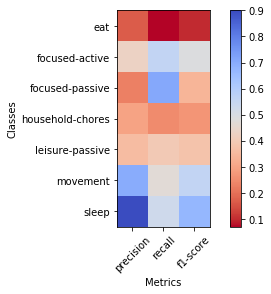

In [18]:
pr.plot_classification_report(r_fulldf, title='', with_avg_total=False, cmap=plt.cm.coolwarm_r)

In [19]:
clf3 = svm.SVC(kernel='poly', cache_size=1000, C=grid_lin.best_params_['C'])
clf3.fit(X=train[feature_list], y=train['activity'])
print(hp.report(test, clf3.predict(test.iloc[:, 3:15])))

                  precision    recall  f1-score   support

             eat       0.20      0.07      0.11        14
  focused-active       0.53      0.56      0.54        18
 focused-passive       0.26      0.71      0.38         7
household-chores       0.40      0.33      0.36        12
 leisure-passive       0.47      0.75      0.58        20
        movement       0.86      0.40      0.55        15
           sleep       0.91      0.59      0.71        17

     avg / total       0.55      0.50      0.49       103




## Now, we can run the same steps above with multiple experiments! Time to have fun!!

In [20]:
r = hp.run_flow(df, feature_list)

408 train examples and 103 test examples
Best params for linear kernel: {'C': 1.0} with score 0.37195
--- test results for linear kernel:
                  precision    recall  f1-score   support

             eat       0.33      0.20      0.25        10
  focused-active       0.44      0.69      0.54        16
 focused-passive       0.29      0.11      0.16        18
household-chores       0.29      0.40      0.33        10
 leisure-passive       0.50      0.53      0.51        19
        movement       0.57      0.62      0.59        13
           sleep       0.59      0.59      0.59        17

     avg / total       0.44      0.46      0.43       103

Best params for RBF kernel: {'C': 10.0, 'gamma': 0.10000000000000001} with score 0.43293
--- test results for RBF kernel:
                  precision    recall  f1-score   support

             eat       0.20      0.20      0.20        10
  focused-active       0.47      0.44      0.45        16
 focused-passive       0.23      0.17   

[0.0, 0.0, 0.0]
[0.72, 0.62, 0.67]
[0.29, 0.38, 0.33]
[0.36, 0.38, 0.37]
[0.35, 0.58, 0.44]
[0.32, 0.43, 0.36]
[0.85, 0.65, 0.73]


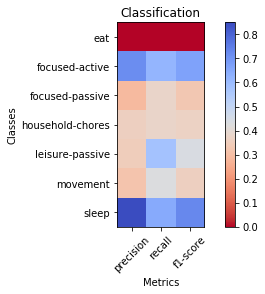

In [67]:
pr.plot_classification_report(r[1], cmap=plt.cm.coolwarm_r)

136 train examples and 35 test examples
Best params for linear kernel: {'C': 1.0} with score 0.47321
--- test results for linear kernel:
                  precision    recall  f1-score   support

             eat       0.00      0.00      0.00         1
  focused-active       0.00      0.00      0.00         5
 focused-passive       0.50      0.50      0.50         4
household-chores       0.20      0.25      0.22         4
 leisure-passive       0.57      0.67      0.62         6
        movement       0.57      0.67      0.62         6
           sleep       0.58      0.78      0.67         9

     avg / total       0.43      0.51      0.46        35



/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best params for RBF kernel: {'C': 10.0, 'gamma': 0.10000000000000001} with score 0.57143
--- test results for RBF kernel:
                  precision    recall  f1-score   support

             eat       0.00      0.00      0.00         1
  focused-active       0.80      0.80      0.80         5
 focused-passive       0.50      0.50      0.50         4
household-chores       0.17      0.25      0.20         4
 leisure-passive       1.00      0.33      0.50         6
        movement       0.71      0.83      0.77         6
           sleep       0.73      0.89      0.80         9

     avg / total       0.67      0.63      0.62        35

                  precision    recall  f1-score   support

             eat       0.00      0.00      0.00         1
  focused-active       0.00      0.00      0.00         5
 focused-passive       0.50      0.50      0.50         4
household-chores       0.20      0.25      0.22         4
 leisure-passive       0.57      0.67      0.62         6
    

/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


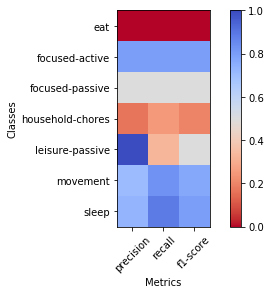

In [22]:
u0 = hp.user_data(df, 0)
r0 = hp.run_flow(u0, feature_list)
print (r0[0])
print (r0[1])
pr.plot_classification_report(r0[1], title ='')


57 train examples and 15 test examples
Best params for linear kernel: {'C': 1.0} with score 0.66667
--- test results for linear kernel:
                 precision    recall  f1-score   support

            eat       0.00      0.00      0.00         0
 focused-active       0.50      0.43      0.46         7
leisure-passive       0.50      0.50      0.50         6
       movement       1.00      1.00      1.00         2

    avg / total       0.57      0.53      0.55        15



/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Best params for RBF kernel: {'C': 100.0, 'gamma': 0.10000000000000001} with score 0.77083
--- test results for RBF kernel:
                 precision    recall  f1-score   support

            eat       0.00      0.00      0.00         0
 focused-active       0.50      0.29      0.36         7
leisure-passive       0.50      0.67      0.57         6
       movement       1.00      1.00      1.00         2

    avg / total       0.57      0.53      0.53        15

                 precision    recall  f1-score   support

            eat       0.00      0.00      0.00         0
 focused-active       0.50      0.43      0.46         7
leisure-passive       0.50      0.50      0.50         6
       movement       1.00      1.00      1.00         2

    avg / total       0.57      0.53      0.55        15

                 precision    recall  f1-score   support

            eat       0.00      0.00      0.00         0
 focused-active       0.50      0.29      0.36         7
leisure-passive

/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


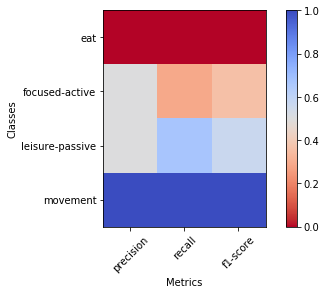

In [23]:
r1 = hp.run_flow(hp.user_data(df, 1), feature_list)
print (r1[0])
print (r1[1])
pr.plot_classification_report(r1[1], title ='')

214 train examples and 54 test examples
Best params for linear kernel: {'C': 100.0} with score 0.44767
--- test results for linear kernel:
                  precision    recall  f1-score   support

             eat       0.56      0.50      0.53        10
  focused-active       0.20      0.25      0.22         4
 focused-passive       0.40      0.36      0.38        11
household-chores       0.43      0.27      0.33        11
 leisure-passive       0.10      0.14      0.12         7
        movement       0.43      0.43      0.43         7
           sleep       0.67      1.00      0.80         4

     avg / total       0.40      0.39      0.39        54

Best params for RBF kernel: {'C': 10.0, 'gamma': 0.01} with score 0.42442
--- test results for RBF kernel:
                  precision    recall  f1-score   support

             eat       0.33      0.10      0.15        10
  focused-active       0.20      0.50      0.29         4
 focused-passive       0.25      0.09      0.13       

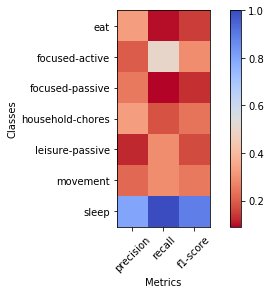

In [25]:
r2 = hp.run_flow(hp.user_data(df, 2), feature_list)
print (r2[0])
print (r2[1])
pr.plot_classification_report(r2[1], title ='')

In [26]:
hp.count_by(df, 'activity')

activity
eat                 53
focused-active      88
focused-passive     73
household-chores    68
leisure-passive     89
movement            65
sleep               75
Name: user, dtype: int64

### 2 - Is eating the problem??

In [27]:
df_reduced = hp.filter_out(df, 'activity', ['eat'])
df_reduced.groupby('activity').count()['user']

activity
focused-active      88
focused-passive     73
household-chores    68
leisure-passive     89
movement            65
sleep               75
Name: user, dtype: int64

In [28]:
reduced = hp.run_flow(df_reduced, feature_list)

366 train examples and 92 test examples
Best params for linear kernel: {'C': 1.0} with score 0.44932
--- test results for linear kernel:
                  precision    recall  f1-score   support

  focused-active       0.46      0.63      0.53        19
 focused-passive       0.20      0.25      0.22        12
household-chores       0.60      0.46      0.52        13
 leisure-passive       0.50      0.62      0.56        16
        movement       0.64      0.75      0.69        12
           sleep       0.86      0.30      0.44        20

     avg / total       0.56      0.50      0.50        92

Best params for RBF kernel: {'C': 1.0, 'gamma': 1.0} with score 0.49324
--- test results for RBF kernel:
                  precision    recall  f1-score   support

  focused-active       0.70      0.74      0.72        19
 focused-passive       0.50      0.33      0.40        12
household-chores       0.33      0.31      0.32        13
 leisure-passive       0.50      0.50      0.50        16


In [31]:
reduced = hp.run_flow(hp.user_data(df_reduced, 0), feature_list)

131 train examples and 33 test examples
Best params for linear kernel: {'C': 10.0} with score 0.62037
--- test results for linear kernel:
                  precision    recall  f1-score   support

  focused-active       0.00      0.00      0.00         5
 focused-passive       0.56      0.62      0.59         8
household-chores       0.50      0.25      0.33         4
 leisure-passive       0.33      0.20      0.25         5
        movement       0.71      0.83      0.77         6
           sleep       0.62      1.00      0.77         5

     avg / total       0.47      0.52      0.48        33

Best params for RBF kernel: {'C': 10.0, 'gamma': 0.01} with score 0.67593
--- test results for RBF kernel:
                  precision    recall  f1-score   support

  focused-active       0.00      0.00      0.00         5
 focused-passive       0.50      0.62      0.56         8
household-chores       0.33      0.25      0.29         4
 leisure-passive       0.50      0.40      0.44        

# Defining hierarchy

### 1 - Splitting database into movement categories (movement, household chores and exercise) and all others

In [32]:
df.groupby('move').count(run)['user']

NameError: name 'run' is not defined

In [34]:
mvres = hp.run_flow(df, feature_list, labelName='move')

408 train examples and 103 test examples
Best params for linear kernel: {'C': 0.10000000000000001} with score 0.88415
--- test results for linear kernel:
             precision    recall  f1-score   support

       move       0.90      0.83      0.86        23
      still       0.95      0.97      0.96        80

avg / total       0.94      0.94      0.94       103

Best params for RBF kernel: {'C': 10.0, 'gamma': 0.10000000000000001} with score 0.88110
--- test results for RBF kernel:
             precision    recall  f1-score   support

       move       0.86      0.83      0.84        23
      still       0.95      0.96      0.96        80

avg / total       0.93      0.93      0.93       103



[0.9, 0.83, 0.86]
[0.95, 0.97, 0.96]


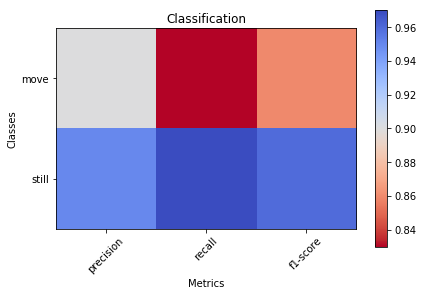

In [35]:
pr.plot_classification_report(mvres[0])

In [39]:
mvresu = [hp.run_flow(hp.user_data(df, user), feature_list, labelName='move') for user in range(3)]

136 train examples and 35 test examples
Best params for linear kernel: {'C': 0.10000000000000001} with score 0.87500
--- test results for linear kernel:
             precision    recall  f1-score   support

       move       1.00      0.75      0.86         8
      still       0.93      1.00      0.96        27

avg / total       0.95      0.94      0.94        35

Best params for RBF kernel: {'C': 100.0, 'gamma': 0.01} with score 0.90179
--- test results for RBF kernel:
             precision    recall  f1-score   support

       move       1.00      0.88      0.93         8
      still       0.96      1.00      0.98        27

avg / total       0.97      0.97      0.97        35

57 train examples and 15 test examples
Best params for linear kernel: {'C': 0.10000000000000001} with score 0.95833
--- test results for linear kernel:
             precision    recall  f1-score   support

       move       1.00      1.00      1.00         1
      still       1.00      1.00      1.00        

In [40]:
scores = []
for i in mvresu:
    scores.append(pr.fscore_from_report(i)) 
print(scores)

['0.97', '1.00', '0.95']


### 1 - Split data by movement intensity:
 * group 1 = movement, household chores, exercise
 

In [42]:
df_stillcls = hp.filter_out(df, 'activity', movelist)
hp.count_by(df_stillcls, 'activity')

activity
eat                53
focused-active     88
focused-passive    73
leisure-passive    89
sleep              75
Name: user, dtype: int64

302 train examples and 76 test examples
Best params for linear kernel: {'C': 0.10000000000000001} with score 0.42623
--- test results for linear kernel:
                 precision    recall  f1-score   support

            eat       0.00      0.00      0.00        12
 focused-active       0.62      0.68      0.65        19
focused-passive       0.44      0.47      0.46        17
leisure-passive       0.35      0.44      0.39        18
          sleep       0.57      0.80      0.67        10

    avg / total       0.41      0.49      0.44        76



/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best params for RBF kernel: {'C': 100.0, 'gamma': 0.01} with score 0.52049
--- test results for RBF kernel:
                 precision    recall  f1-score   support

            eat       0.33      0.08      0.13        12
 focused-active       0.64      0.74      0.68        19
focused-passive       0.47      0.41      0.44        17
leisure-passive       0.39      0.50      0.44        18
          sleep       0.69      0.90      0.78        10

    avg / total       0.50      0.53      0.50        76

[0.33, 0.08, 0.13]
[0.64, 0.74, 0.68]
[0.47, 0.41, 0.44]
[0.39, 0.5, 0.44]
[0.69, 0.9, 0.78]


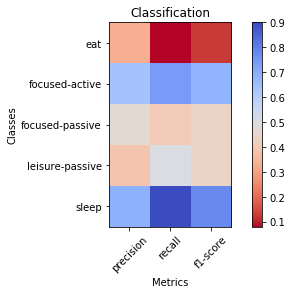

In [45]:
r = hp.run_flow(df_stillcls, feature_list)
pr.plot_classification_report(r[1], cmap=plt.cm.coolwarm_r)

In [47]:
mvres = [hp.run_flow(hp.user_data(df_stillcls, user), feature_list) for user in range(3)]

92 train examples and 24 test examples
Best params for linear kernel: {'C': 10.0} with score 0.57895
--- test results for linear kernel:
                 precision    recall  f1-score   support

            eat       0.00      0.00      0.00         0
 focused-active       0.43      0.75      0.55         4
focused-passive       0.67      0.57      0.62         7
leisure-passive       0.50      0.33      0.40         6
          sleep       0.67      0.57      0.62         7

    avg / total       0.59      0.54      0.55        24



/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Best params for RBF kernel: {'C': 100.0, 'gamma': 0.10000000000000001} with score 0.61842
--- test results for RBF kernel:
                 precision    recall  f1-score   support

            eat       0.00      0.00      0.00         0
 focused-active       0.50      0.75      0.60         4
focused-passive       0.80      0.57      0.67         7
leisure-passive       0.33      0.17      0.22         6
          sleep       0.67      0.86      0.75         7

    avg / total       0.59      0.58      0.57        24

51 train examples and 13 test examples
Best params for linear kernel: {'C': 10.0} with score 0.68182
--- test results for linear kernel:
                 precision    recall  f1-score   support

            eat       0.50      1.00      0.67         2
 focused-active       0.60      0.50      0.55         6
leisure-passive       0.50      0.40      0.44         5

    avg / total       0.55      0.54      0.53        13



/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Best params for RBF kernel: {'C': 10.0, 'gamma': 0.10000000000000001} with score 0.68182
--- test results for RBF kernel:
                 precision    recall  f1-score   support

            eat       0.67      1.00      0.80         2
 focused-active       1.00      0.50      0.67         6
leisure-passive       0.57      0.80      0.67         5

    avg / total       0.78      0.69      0.69        13

158 train examples and 40 test examples
Best params for linear kernel: {'C': 1.0} with score 0.51562
--- test results for linear kernel:
                 precision    recall  f1-score   support

            eat       0.86      0.50      0.63        12
 focused-active       0.50      0.60      0.55         5
focused-passive       0.20      0.40      0.27         5
leisure-passive       0.50      0.33      0.40         9
          sleep       0.82      1.00      0.90         9

    avg / total       0.64      0.57      0.58        40

Best params for RBF kernel: {'C': 1.0, 'gamma': 0.0

/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [49]:
includelist = ['movement', 'household-chores', 'exercise-high', 'exercise-low']
df_movecls = hp.filter_in(df, 'activity', includelist)
hp.count_by(df_movecls, 'activity')

activity
household-chores    68
movement            65
Name: user, dtype: int64

106 train examples and 27 test examples
Best params for linear kernel: {'C': 0.10000000000000001} with score 0.64773
--- test results for linear kernel:
                  precision    recall  f1-score   support

household-chores       0.47      0.54      0.50        13
        movement       0.50      0.43      0.46        14

     avg / total       0.48      0.48      0.48        27

Best params for RBF kernel: {'C': 1.0, 'gamma': 0.10000000000000001} with score 0.68182
--- test results for RBF kernel:
                  precision    recall  f1-score   support

household-chores       0.45      0.69      0.55        13
        movement       0.43      0.21      0.29        14

     avg / total       0.44      0.44      0.41        27

[0.45, 0.69, 0.55]
[0.43, 0.21, 0.29]


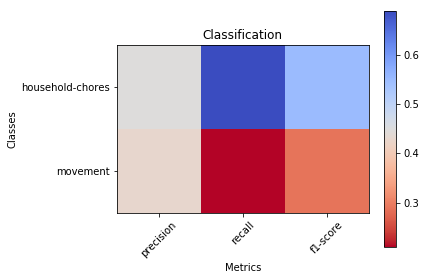

In [52]:
r = hp.run_flow(df_movecls, feature_list)
pr.plot_classification_report(r[1], cmap=plt.cm.coolwarm_r)

activity
household-chores    28
movement            27
Name: user, dtype: int64
44 train examples and 11 test examples
Best params for linear kernel: {'C': 10.0} with score 0.69444
--- test results for linear kernel:
                  precision    recall  f1-score   support

household-chores       0.86      0.86      0.86         7
        movement       0.75      0.75      0.75         4

     avg / total       0.82      0.82      0.82        11

Best params for RBF kernel: {'C': 1.0, 'gamma': 1.0} with score 0.69444
--- test results for RBF kernel:
                  precision    recall  f1-score   support

household-chores       0.83      0.71      0.77         7
        movement       0.60      0.75      0.67         4

     avg / total       0.75      0.73      0.73        11

[0.83, 0.71, 0.77]
[0.6, 0.75, 0.67]


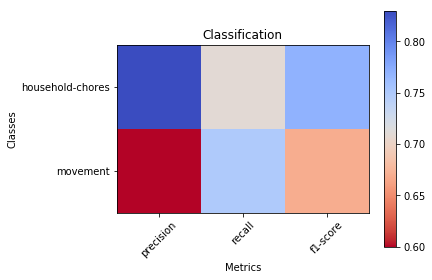

In [54]:
ju_move = hp.user_data(df_movecls, 0)
print(hp.count_by(ju_move, 'activity'))
r = hp.run_flow(ju_move, feature_list)
pr.plot_classification_report(r[1], cmap=plt.cm.coolwarm_r)

activity
household-chores    40
movement            30
Name: user, dtype: int64
56 train examples and 14 test examples
Best params for linear kernel: {'C': 100.0} with score 0.66667
--- test results for linear kernel:
                  precision    recall  f1-score   support

household-chores       0.55      0.86      0.67         7
        movement       0.67      0.29      0.40         7

     avg / total       0.61      0.57      0.53        14

Best params for RBF kernel: {'C': 10.0, 'gamma': 1.0} with score 0.62500
--- test results for RBF kernel:
                  precision    recall  f1-score   support

household-chores       0.60      0.86      0.71         7
        movement       0.75      0.43      0.55         7

     avg / total       0.67      0.64      0.63        14

[0.6, 0.86, 0.71]
[0.75, 0.43, 0.55]


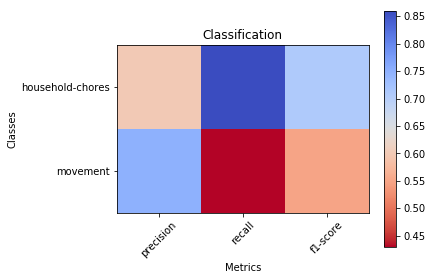

In [55]:
edu_move = hp.user_data(df_movecls, 2)
print(hp.count_by(edu_move, 'activity'))
r = hp.run_flow(edu_move, feature_list)
pr.plot_classification_report(r[1], cmap=plt.cm.coolwarm_r)

In [56]:
for activ in df_stillcls.activity.unique():
    print ('----------------------------------------------------------------')
    dfa = df_stillcls
    df_onevsall = hp.add_partition(df=dfa, includelist=[activ], pname=activ, labelIn=activ, labelOut='others')
    print(df_onevsall.groupby(activ).count()['user'])
    hp.run_flow(df_onevsall, feature_list, labelName=activ)

----------------------------------------------------------------
eat
eat        53
others    325
Name: user, dtype: int64
302 train examples and 76 test examples
Best params for linear kernel: {'C': 0.01} with score 0.86885
--- test results for linear kernel:
             precision    recall  f1-score   support

        eat       0.00      0.00      0.00        13
     others       0.83      1.00      0.91        63

avg / total       0.69      0.83      0.75        76



/home/ju/workspace/HeRV_analysis/hervpd.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[pname] = np.where(df['activity'].isin(includelist), labelIn, labelOut)
/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best params for RBF kernel: {'C': 0.01, 'gamma': 0.01} with score 0.86885
--- test results for RBF kernel:
             precision    recall  f1-score   support

        eat       0.00      0.00      0.00        13
     others       0.83      1.00      0.91        63

avg / total       0.69      0.83      0.75        76

----------------------------------------------------------------
focused-active
focused-active     88
others            290
Name: user, dtype: int64
302 train examples and 76 test examples


/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ju/workspace/HeRV_analysis/hervpd.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[pname] = np.where(df['activity'].isin(includelist), labelIn, labelOut)


Best params for linear kernel: {'C': 1.0} with score 0.75820
--- test results for linear kernel:
                precision    recall  f1-score   support

focused-active       0.00      0.00      0.00        14
        others       0.82      1.00      0.90        62

   avg / total       0.67      0.82      0.73        76



/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best params for RBF kernel: {'C': 1.0, 'gamma': 1.0} with score 0.81557
--- test results for RBF kernel:
                precision    recall  f1-score   support

focused-active       1.00      0.50      0.67        14
        others       0.90      1.00      0.95        62

   avg / total       0.92      0.91      0.90        76

----------------------------------------------------------------
focused-passive
focused-passive     73
others             305
Name: user, dtype: int64
302 train examples and 76 test examples


/home/ju/workspace/HeRV_analysis/hervpd.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[pname] = np.where(df['activity'].isin(includelist), labelIn, labelOut)


Best params for linear kernel: {'C': 10.0} with score 0.81557
--- test results for linear kernel:
                 precision    recall  f1-score   support

focused-passive       0.20      0.11      0.14         9
         others       0.89      0.94      0.91        67

    avg / total       0.81      0.84      0.82        76

Best params for RBF kernel: {'C': 100.0, 'gamma': 0.01} with score 0.82787
--- test results for RBF kernel:
                 precision    recall  f1-score   support

focused-passive       0.33      0.11      0.17         9
         others       0.89      0.97      0.93        67

    avg / total       0.82      0.87      0.84        76

----------------------------------------------------------------
leisure-passive
leisure-passive     89
others             289
Name: user, dtype: int64
302 train examples and 76 test examples


/home/ju/workspace/HeRV_analysis/hervpd.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[pname] = np.where(df['activity'].isin(includelist), labelIn, labelOut)


Best params for linear kernel: {'C': 0.01} with score 0.75410
--- test results for linear kernel:
                 precision    recall  f1-score   support

leisure-passive       0.00      0.00      0.00        17
         others       0.78      1.00      0.87        59

    avg / total       0.60      0.78      0.68        76



/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best params for RBF kernel: {'C': 100.0, 'gamma': 1.0} with score 0.77049
--- test results for RBF kernel:
                 precision    recall  f1-score   support

leisure-passive       0.50      0.47      0.48        17
         others       0.85      0.86      0.86        59

    avg / total       0.77      0.78      0.77        76

----------------------------------------------------------------
sleep
others    303
sleep      75
Name: user, dtype: int64
302 train examples and 76 test examples


/home/ju/workspace/HeRV_analysis/hervpd.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[pname] = np.where(df['activity'].isin(includelist), labelIn, labelOut)


Best params for linear kernel: {'C': 0.10000000000000001} with score 0.87705
--- test results for linear kernel:
             precision    recall  f1-score   support

     others       0.85      1.00      0.92        61
      sleep       1.00      0.27      0.42        15

avg / total       0.88      0.86      0.82        76

Best params for RBF kernel: {'C': 100.0, 'gamma': 0.01} with score 0.94262
--- test results for RBF kernel:
             precision    recall  f1-score   support

     others       0.91      0.98      0.94        61
      sleep       0.90      0.60      0.72        15

avg / total       0.91      0.91      0.90        76



### Split still activities by sleep vc others

In [ ]:
hp.countExamplesByActivity(df_stillcls)
df_partsleep = hp.addPartition(df=df_stillcls, includelist=['sleep'], pname='sleep', labelIn='sleep', labelOut='wake')
print(df_partsleep.groupby('sleep').count()['user'])

In [ ]:
 hp.runFlow(df_partsleep, labelName='sleep')

In [ ]:
ju_sleep = hp.userRows(df_partsleep, 0) 
hp.runFlow(ju_sleep, labelName='sleep')

In [ ]:
edu_sleep = hp.userRows(df_partsleep, 2) 
hp.runFlow(edu_sleep, labelName='sleep')

In [ ]:
df_wake = hp.excludeActivities(df_stillcls,['sleep'] )
hp.countExamplesByActivity(df_wake)

In [ ]:
hp.runFlow(df_wake)

In [ ]:
hp.runFlowByUser(df_wake)

### Split by passive vs active sitting activities

In [ ]:
df_actlvl = hp.addPartition(df_wake, includelist=['focused-passive', 'leisure-passive'], pname='actlvl', labelIn='passive', labelOut='active')
print(df_passive.groupby('actlvl').count()['user'])

In [ ]:
hp.runFlow(df_actlvl, labelName='actlvl')

In [ ]:
hp.runFlowByUser(df_actlvl, labelName='actlvl')

In [ ]:
df_passive = hp.filterActivities(df_actlvl, ['leisure-passive', 'focused-passive'])
hp.countExamplesByActivity(df_passive)

In [ ]:
hp.runFlow(df_passive)

In [ ]:
hp.runFlow(hp.userRows(df_passive, 0))

In [ ]:
hp.runFlow(hp.userRows(df_passive, 2))

In [ ]:
df_active = hp.excludeActivities(df_actlvl, ['leisure-passive', 'focused-passive'])
hp.countExamplesByActivity(df_active)

In [ ]:
hp.runFlow(df_active)

In [ ]:
hp.runFlowByUser(df_active)